In [1]:
import pathlib
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import PIL

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test')

data_dir_train, data_dir_test

(PosixPath('/content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train'),
 PosixPath('/content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test'))

Define Train and Test data paths

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Define data sets

In [5]:
batch_size = 32
img_height = 180
img_width = 180

#### Training Dataset with image resized to 180*180

In [6]:
train_ds = keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


#### Validation datatset with image resized to 180*180

In [7]:
from re import sub
val_ds = keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Data Visualization. Looking at one instance of each class

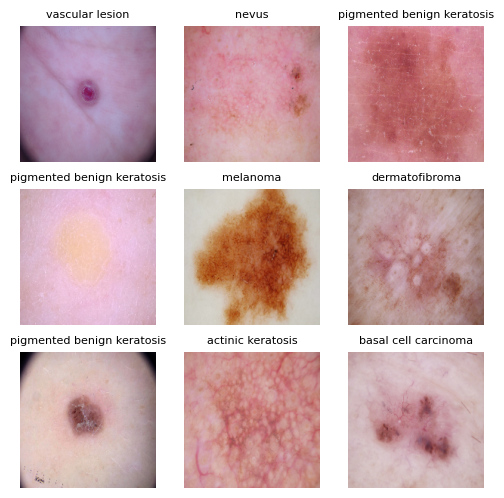

In [9]:
fig = plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.title(class_names[labels[i]], size=8)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")


#### See the batch shapes

In [10]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break


(32, 180, 180, 3)
(32,)


#### Prefetch and cache dataset for better performance during training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Creating a standard CNN model with a Rescaling layer for image pixel values. This has no drop outs or Batch Normalization

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Compiling the model

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,982,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,081,193 (7.94 MB)

 Trainable params: 2,081,193 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the model

In [15]:
epochs=20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.1954 - loss: 2.1636 - val_accuracy: 0.3020 - val_loss: 1.9336
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2697 - loss: 1.9258 - val_accuracy: 0.3289 - val_loss: 1.8108
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3724 - loss: 1.7401 - val_accuracy: 0.3758 - val_loss: 1.7080
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4662 - loss: 1.5137 - val_accuracy: 0.4720 - val_loss: 1.5232
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4931 - loss: 1.4306 - val_accuracy: 0.5302 - val_loss: 1.4019
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5198 - loss: 1.3236 - val_accuracy: 0.4944 - val_loss: 1.4898
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5536 - loss: 1.2571 - val_accuracy: 0.4631 - val_loss: 1.5003
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5731 - loss: 1.2138 - val_accuracy: 0.5257 - v

#### Visualizing training results

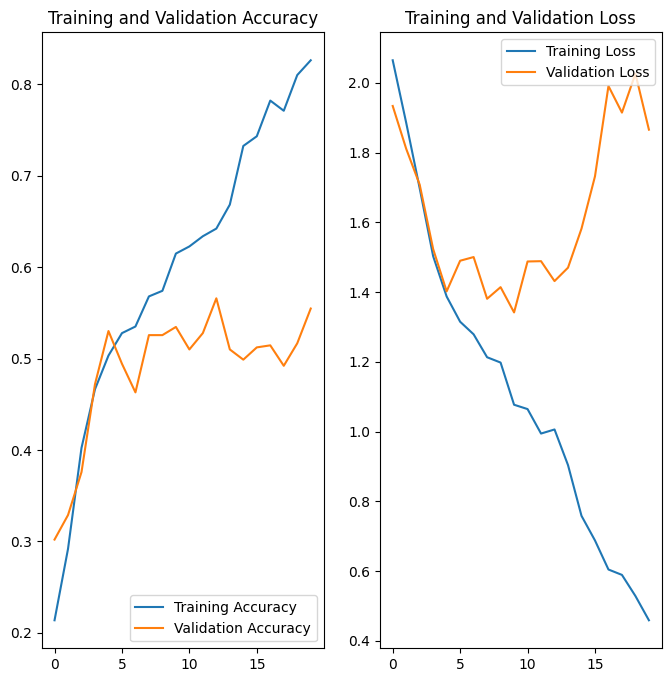

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### As per above observation, we clearly see a huge difference between the training accuracy and Validation accuracy. Also, the training loss is descreasing steadily but validation loss is not. This is a clear sign of model overfitting.

## Data Augmentation

#### Creating an Augmentation layer in the model to add some variations to the existing images

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#### Visualizing the augmented data for 1 instance

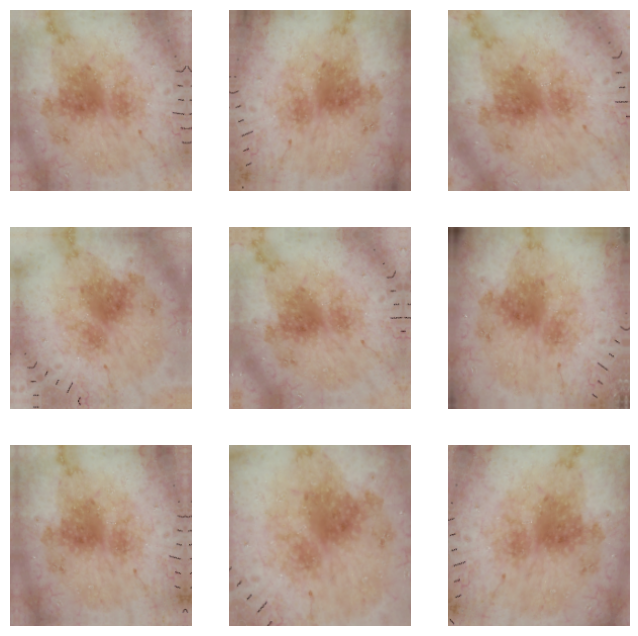

In [18]:
figure = plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### Creating a new model using the augmented layers and drop out layers

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,982,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,081,193 (7.94 MB)

 Trainable params: 2,081,193 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

#### Running the model with Augementation and Drop out layers for 20 epochs

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.1647 - loss: 2.1655 - val_accuracy: 0.1924 - val_loss: 2.0297
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2471 - loss: 2.0168 - val_accuracy: 0.3848 - val_loss: 1.8653
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3548 - loss: 1.8115 - val_accuracy: 0.4541 - val_loss: 1.5739
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4417 - loss: 1.5578 - val_accuracy: 0.4855 - val_loss: 1.4759
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5180 - loss: 1.3938 - val_accuracy: 0.4877 - val_loss: 1.4347
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5050 - loss: 1.3805 - val_accuracy: 0.5101 - val_loss: 1.3959
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4910 - loss: 1.4407 - val_accuracy: 0.4720 - val_loss: 1.5224
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4839 - loss: 1.3949 - val_accuracy: 0.5078 - v

#### From above output, we can see that the difference between training and validation accuracy after adding Augmentation and drop out layers has decreased.
#### But at the same time, accuracy has also decreased. This may be due to the fact that with a small dataset and less no. of neurons the drop out is not a good idea. Hence we have solved overfitting here, but it seems now the model is an underfit

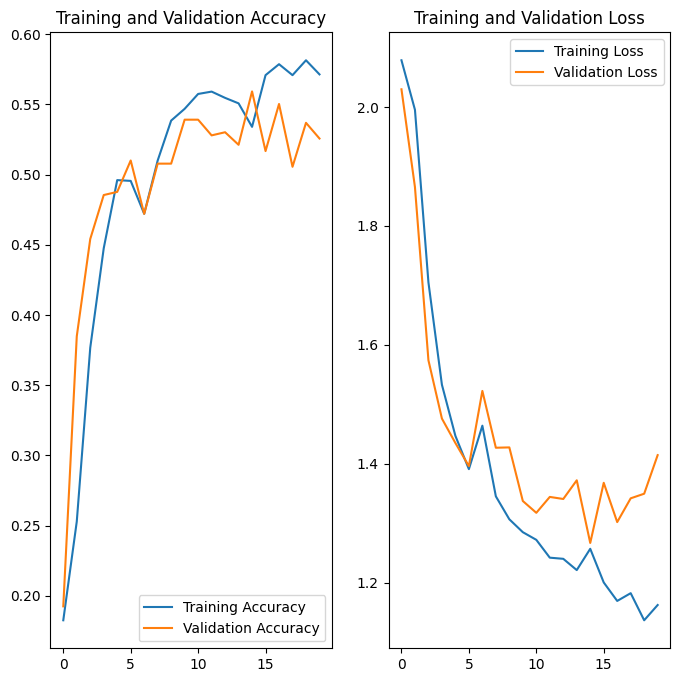

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Find the distribution of classes in the training dataset i.e. Finding class imbalance

In [24]:
for class_name in class_names:
  image_count_class = len(list(data_dir_train.glob(class_name+'/*.jpg')))
  print(class_name, image_count_class)


actinic keratosis 114
basal cell carcinoma 376
dermatofibroma 95
melanoma 438
nevus 357
pigmented benign keratosis 462
seborrheic keratosis 77
squamous cell carcinoma 181
vascular lesion 139


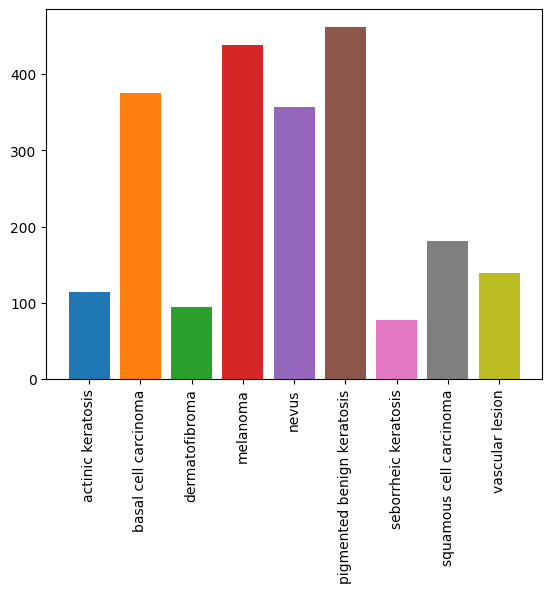

In [25]:
for class_name in class_names:
  image_count_class = len(list(data_dir_train.glob(class_name+'/*.jpg')))
  plt.bar(class_name, image_count_class)
  plt.xticks(rotation=90)

plt.show()

#### Hence we can see that classes "**seborrheic keratosis**" and "**dermatofibroma**" has the least no. of samples and classes "**pigmented benign keratosis**" and "**basal cell carcinoma**" has the highest no. of samples.
#### Here it might make sense to make the classes samples similar to the highest no. of samples

### Using Augmentor to augment the classes and handle class imbalance

In [26]:
!pip install Augmentor

In [27]:
import Augmentor

#### Using Augmentor library to augment the classes with low number of samples.

In [28]:
class_names_to_augment1 = ['actinic keratosis','dermatofibroma','seborrheic keratosis','vascular lesion']
class_names_to_augment2 = ['basal cell carcinoma','melanoma','nevus','pigmented benign keratosis','squamous cell carcinoma']

####  Adding 500 samples for sparse classes to make them similar to classes with high no. of samples

In [29]:
path_to_training_dataset=data_dir_train

for class_name in class_names_to_augment1:
    p = Augmentor.Pipeline(str(path_to_training_dataset) +"/"+ class_name)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDECE4D35B0>: 100%|██████████| 500/500 [00:26<00:00, 18.58 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDECE453F40>: 100%|██████████| 500/500 [00:20<00:00, 24.60 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDF303CBE20>: 100%|██████████| 500/500 [00:45<00:00, 10.96 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDECE4D27A0>: 100%|██████████| 500/500 [00:21<00:00, 22.85 Samples/s]


#### Adding 200 samples for already high no of samples

In [30]:
for class_name in class_names_to_augment2:
    p = Augmentor.Pipeline(str(path_to_training_dataset) +"/"+ class_name)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(200)

Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDECE3009D0>: 100%|██████████| 200/200 [00:11<00:00, 17.64 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=962x645 at 0x7FDECE20CC40>: 100%|██████████| 200/200 [00:39<00:00,  5.10 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDECE2EBCA0>: 100%|██████████| 200/200 [00:35<00:00,  5.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDECE4D2BC0>: 100%|██████████| 200/200 [00:08<00:00, 23.61 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDECE4D12D0>: 100%|██████████| 200/200 [00:08<00:00, 22.97 Samples/s]


In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

3000


In [32]:
for class_name in class_names:
  image_count_class = len(list(path_to_training_dataset.glob(class_name+'/output/*.jpg*')))
  print(class_name, image_count_class)

actinic keratosis 500
basal cell carcinoma 200
dermatofibroma 500
melanoma 200
nevus 200
pigmented benign keratosis 200
seborrheic keratosis 500
squamous cell carcinoma 200
vascular lesion 500


#### Now creating a new folder with Augmented images

In [33]:
import shutil

for class_name in class_names:
    source_folder = str(data_dir_train)+"/"+class_name+"/output"
    destination_folder = str(data_dir_train)+"/aug/"+class_name
    shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)




In [34]:
for class_name in class_names:
    source_folder = str(data_dir_train)+"/"+class_name
    destination_folder = str(data_dir_train)+"/aug/"+class_name
    shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

#### Looking at class distribution after augmentation

In [35]:
for class_name in class_names:
  image_count_class = len(list(path_to_training_dataset.glob('aug/'+class_name+'/*.jpg*')))
  print(class_name, image_count_class)

actinic keratosis 614
basal cell carcinoma 576
dermatofibroma 595
melanoma 638
nevus 557
pigmented benign keratosis 662
seborrheic keratosis 577
squamous cell carcinoma 381
vascular lesion 639


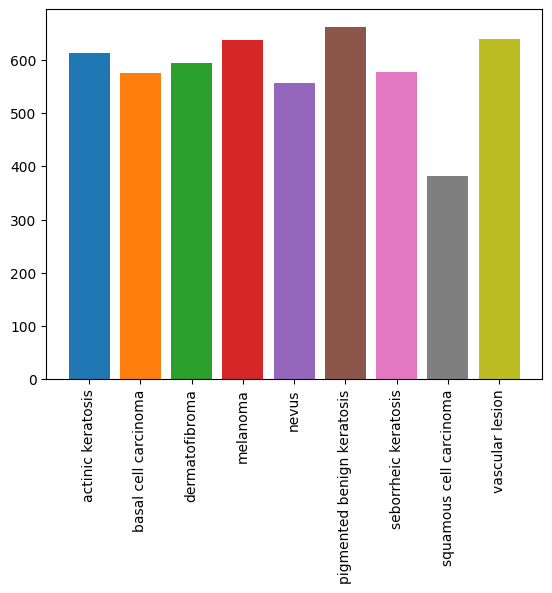

In [36]:
for class_name in class_names:
  image_count_class = len(list(path_to_training_dataset.glob('aug/'+class_name+'/*.jpg*')))
  plt.bar(class_name, image_count_class)
  plt.xticks(rotation=90)

plt.show()

#### Class distribution now looks better

#### Create a new CNN model with new Augmented data

In [37]:
batch_size = 32
img_height = 180
img_width = 180

In [38]:
data_dir_train_new=str(data_dir_train)+"/aug"
data_dir_train_new

'/content/drive/MyDrive/DeepLearning/CNN/CNN_assignment/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/aug'

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_new,
  seed=123,
  validation_split = 0.2,
  subset="training",
  labels="inferred",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8239 files belonging to 9 classes.
Using 6592 files for training.


In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_new,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  labels="inferred",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8239 files belonging to 9 classes.
Using 1647 files for validation.


In [41]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       1,982,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,081,193 (7.94 MB)

 Trainable params: 2,081,193 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.2185 - loss: 1.9803 - val_accuracy: 0.4487 - val_loss: 1.4801
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 76s 248ms/step - accuracy: 0.4730 - loss: 1.4132 - val_accuracy: 0.5046 - val_loss: 1.3770
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 85s 264ms/step - accuracy: 0.5445 - loss: 1.2325 - val_accuracy: 0.5774 - val_loss: 1.1083
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 80s 256ms/step - accuracy: 0.6200 - loss: 1.0523 - val_accuracy: 0.6740 - val_loss: 0.9200
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 79s 241ms/step - accuracy: 0.6991 - loss: 0.8423 - val_accuracy: 0.7207 - val_loss: 0.7688
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 80s 234ms/step - accuracy: 0.7562 - loss: 0.6941 - val_accuracy: 0.7838 - val_loss: 0.6376
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 80s 223ms/step - accuracy: 0.8213 - loss: 0.5297 - val_accuracy: 0.7790 - val_loss: 0.6793
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 84s 231ms/step - accuracy: 0.8439 - loss: 0

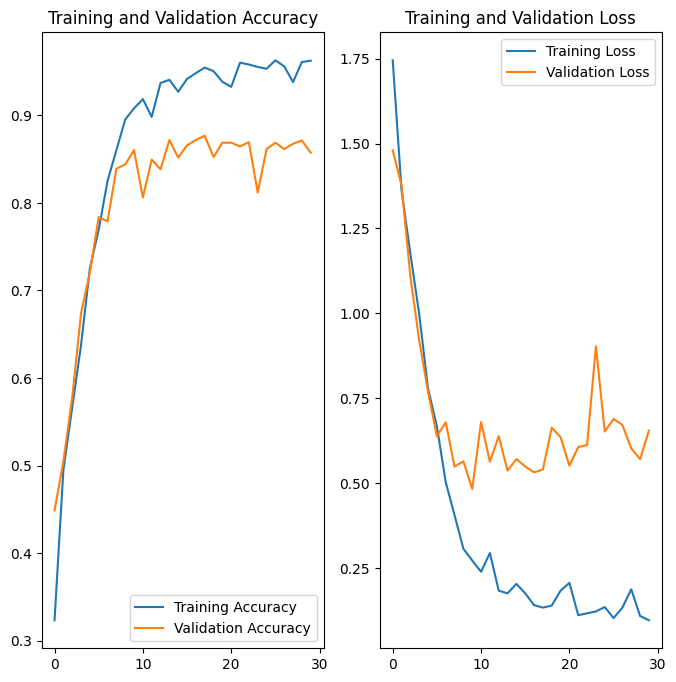

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We see some improvement, but there is still some overfitting. Lets try to add one more drop out layer and see

In [46]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 62s 273ms/step - accuracy: 0.1585 - loss: 2.1795 - val_accuracy: 0.4317 - val_loss: 1.5376
Epoch 2/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 68s 221ms/step - accuracy: 0.4314 - loss: 1.5093 - val_accuracy: 0.4979 - val_loss: 1.3496
Epoch 3/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 84s 231ms/step - accuracy: 0.5379 - loss: 1.2831 - val_accuracy: 0.5191 - val_loss: 1.3620
Epoch 4/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 82s 233ms/step - accuracy: 0.5990 - loss: 1.1105 - val_accuracy: 0.6679 - val_loss: 0.9026
Epoch 5/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 82s 232ms/step - accuracy: 0.6879 - loss: 0.8839 - val_accuracy: 0.7292 - val_loss: 0.8121
Epoch 6/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 81s 227ms/step - accuracy: 0.7588 - loss: 0.7058 - val_accuracy: 0.7529 - val_loss: 0.7440
Epoch 7/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 82s 226ms/step - accuracy: 0.8025 - loss: 0.5630 - val_accuracy: 0.8148 - val_loss: 0.5868
Epoch 8/30
206/206 ━━━━━━━━━━━━━━━━━━━━ 81s 223ms/step - accuracy: 0.8399 - loss: 0

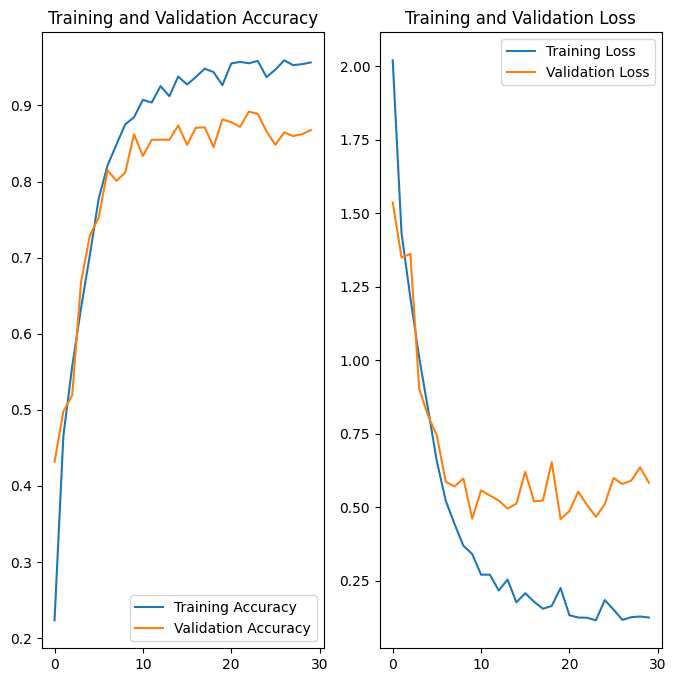

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We see some more improvements in the Accuracy score difference between Training and Validation dataset

#### Lets try to evaluate our model on Test data now

In [50]:
validation_ds = keras.utils.image_dataset_from_directory(
    data_dir_test,
    validation_split=None,
    labels="inferred",
    label_mode="int",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=123,
    verbose=True,
)

Found 118 files belonging to 9 classes.


In [51]:
test_loss, test_acc = model.evaluate(validation_ds)
print(test_loss, test_acc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.3088 - loss: 8.2150
8.143052101135254 0.3813559412956238
